### Настройка среды

In [11]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

Cloning into 'OpticalEncoder'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 468 (delta 48), reused 46 (delta 20), pack-reused 386
Receiving objects: 100% (468/468), 22.57 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (262/262), done.


In [12]:
%cd OpticalEncoder
!dir
!git pull

/content/OpticalEncoder/OpticalEncoder
elements  main.py  notebooks  parameters.py  tests  utilities
Already up to date.


In [13]:
%pip install belashovplot

In [14]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
from itertools import product

In [24]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Распространение от щели

In [46]:
N = 500
size = 40.0E-6

b_spatial_coherence = 50.0E-6
b_time_coherence = 10.0E-9
b_time_relaxation = 1.0E-6
b_mean_samples = 500

b_length = 2.0E-3
b_wavelength = 500E-9
b_distance = b_length*sqrt((size/b_wavelength)**2-1)

## Зависимость от степени пространственной некогерентности и дистанции

In [51]:
distance_samples = 3
coherence_samples = 6
slices = 100

distance_array = numpy.linspace(b_distance*0.1, b_distance, distance_samples)
spatial_coherence_array = numpy.linspace(5.0E-6, 10*size, coherence_samples)

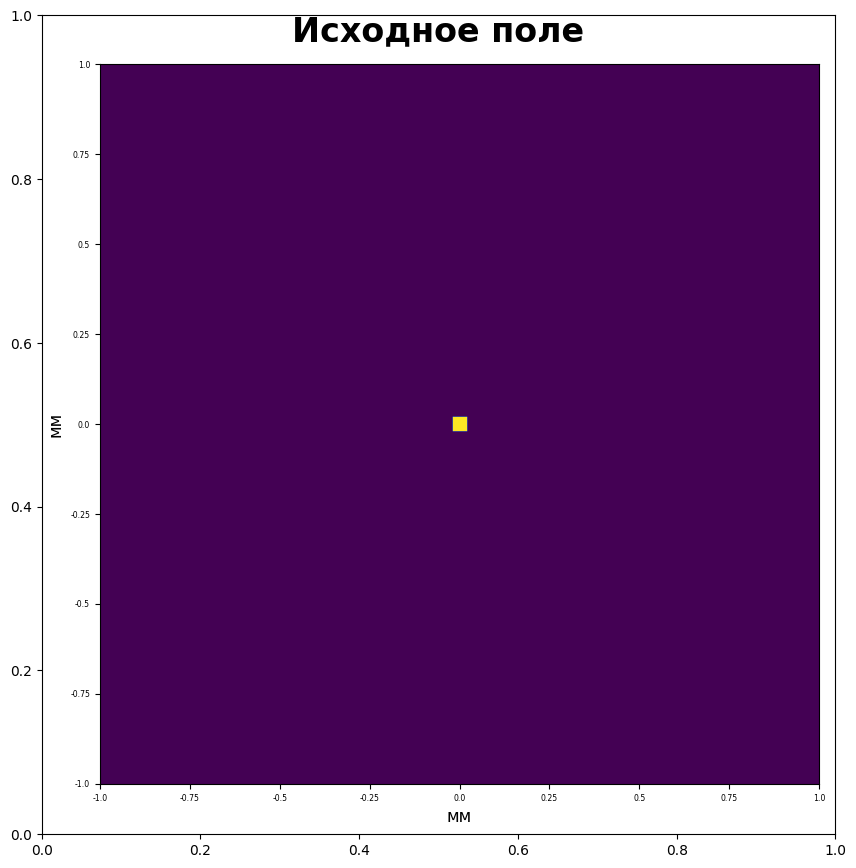

In [52]:
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(b_length*2))
p1 = p0 + int(N*size/b_length)
initial[0,0,p0:p1,p0:p1] = 1.0

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Исходное поле')
formatter, unit = engineering.separatedformatter(b_length, 'м')

axes = plot.axes.add(0,0)
axes.imshow(initial[0,0].abs().cpu(), aspect='auto', extent=[-b_length/2, +b_length/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()

In [53]:
with torch.no_grad():
  results = []
  chunker = CudaMemoryChunker().to(device)
  for (col, spatial_coherence), (row, max_distance) in tqdm(product(enumerate(spatial_coherence_array), enumerate(distance_array)), total=distance_samples*coherence_samples):
    incoherent = Incoherent(spatial_coherence, b_time_coherence, b_time_relaxation, b_mean_samples, N, b_length).to(device)
    result = torch.zeros((slices, N), dtype=torch.float32)
    for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
      propagation = FurrierPropagation(N, b_length, b_wavelength, 1.0, 0.0, distance).to(device)
      chunker.attach_forward(propagation.forward)
      incoherent.attach_forward(chunker.forward)
      result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
    results.append((col, row, spatial_coherence, max_distance, result))
    result = None

100%|██████████| 18/18 [00:30<00:00,  1.68s/it]


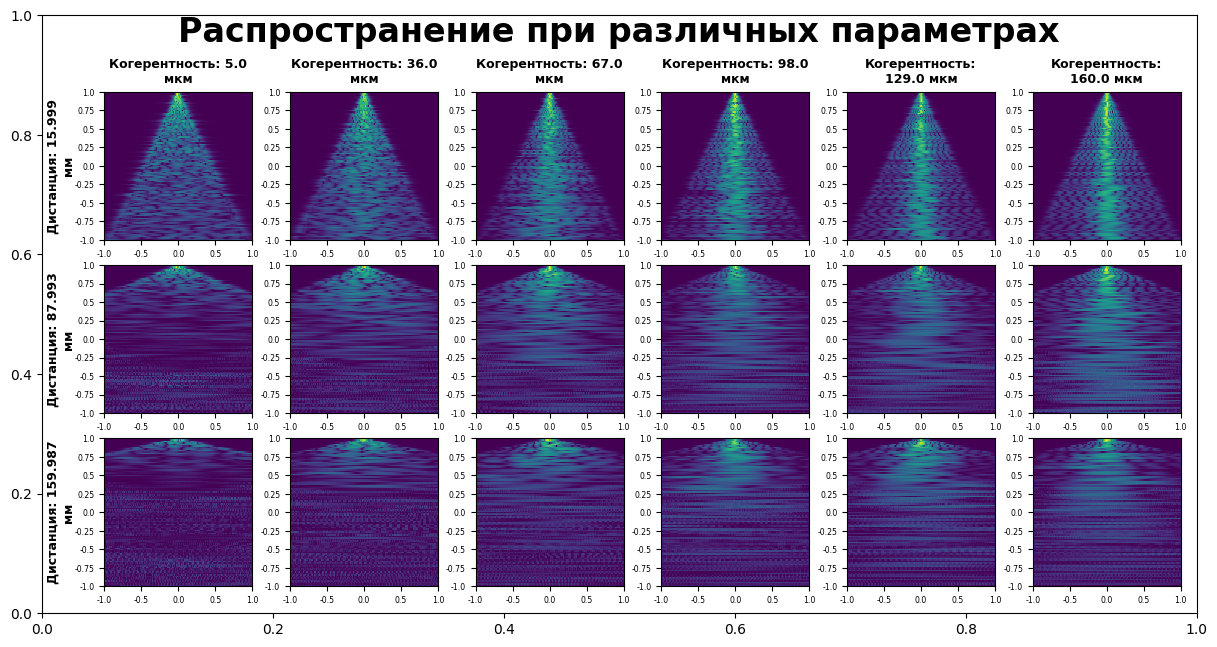

In [54]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распространение при различных параметрах')
kwargs = {'aspect':'auto', 'extent':[-b_length/2,+b_length/2]*2, 'interpolation':'nearest'}
formatter, unit = engineering.separatedformatter(b_length, 'м')

for col, spatial_coherence in enumerate(spatial_coherence_array):
  plot.description.column.top(f"Когерентность: {engineering(spatial_coherence, 'м')}", col)

for row, distance in enumerate(distance_array):
  plot.description.row.left(f"Дистанция: {engineering(distance, 'м')}", row)

for col, row, spatial_coherence, distance, data in results:
  axes = plot.axes.add(col, row)
  axes.imshow(torch.log10(data+0.0001), **kwargs)
  axes.xaxis.set_major_formatter(formatter)
  axes.yaxis.set_major_formatter(formatter)

plot.show()